## Import Dependencies in Python

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
get_ipython().run_line_magic('matplotlib', 'inline')
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import datetime
import quandl
from plotnine import *
import plotly.graph_objects as go

## Import daily data

In [3]:
df = pd.read_csv('daily_data.csv')
df = df.rename(columns={"Unnamed: 0": "date"})
df.set_index('date')
df.index = pd.to_datetime(df['date'],yearfirst=True)
df['date'] = pd.to_datetime(df['date'],yearfirst=True)
df

,date,WTI,BRENT,exxon_close,chevron_close,conoco_close,eog_close,valero_close,baker_close,WTI_increase,...,chevron_increase,chevron_decrease,conoco_increase,conoco_decrease,eog_increase,eog_decrease,valero_increase,valero_decrease,baker_increase,baker_decrease
date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,1990-01-02,22.88,21.20,12.500000,17.281250,9.767180,3.046875,3.456353,25.875000,0,...,0,0,0,0,0,0,0,0,0,0
1990-01-03,1990-01-03,23.81,22.65,12.375000,17.000000,9.576602,3.031250,3.513483,25.500000,1,...,0,1,0,1,0,1,1,0,0,1
1990-01-04,1990-01-04,23.41,22.50,12.250000,16.781250,9.386023,2.953125,3.570612,24.875000,0,...,0,1,0,1,0,1,1,0,0,1
1990-01-05,1990-01-05,23.07,23.13,12.187500,16.531250,9.290733,2.906250,3.599177,24.750000,0,...,0,1,0,1,0,1,1,0,0,1
1990-01-08,1990-01-08,21.64,21.38,12.375000,16.687500,9.481312,2.859375,3.542048,25.000000,0,...,1,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22,2020-05-22,33.49,33.80,44.599998,90.279999,43.279999,52.279999,65.680000,15.120000,0,...,0,1,0,1,0,1,0,1,0,1
2020-05-26,2020-05-26,34.70,33.95,45.910000,93.300003,43.669998,51.439999,68.699997,16.010000,1,...,1,0,1,0,0,1,1,0,1,0
2020-05-27,2020-05-27,32.80,32.73,46.240002,93.900002,44.669998,52.730000,70.180000,16.559999,0,...,1,0,1,0,1,0,1,0,1,0


## Step 1: Plot WTI and BRENT data for to visually inspect time series data

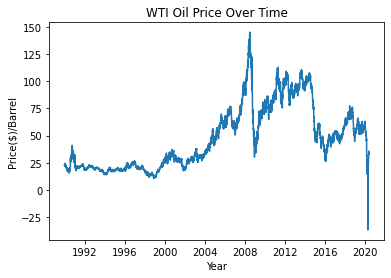

In [4]:
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.title('WTI Oil Price Over Time')
plt.plot(df['WTI'])
plt.rcParams["figure.figsize"] = [18,10]

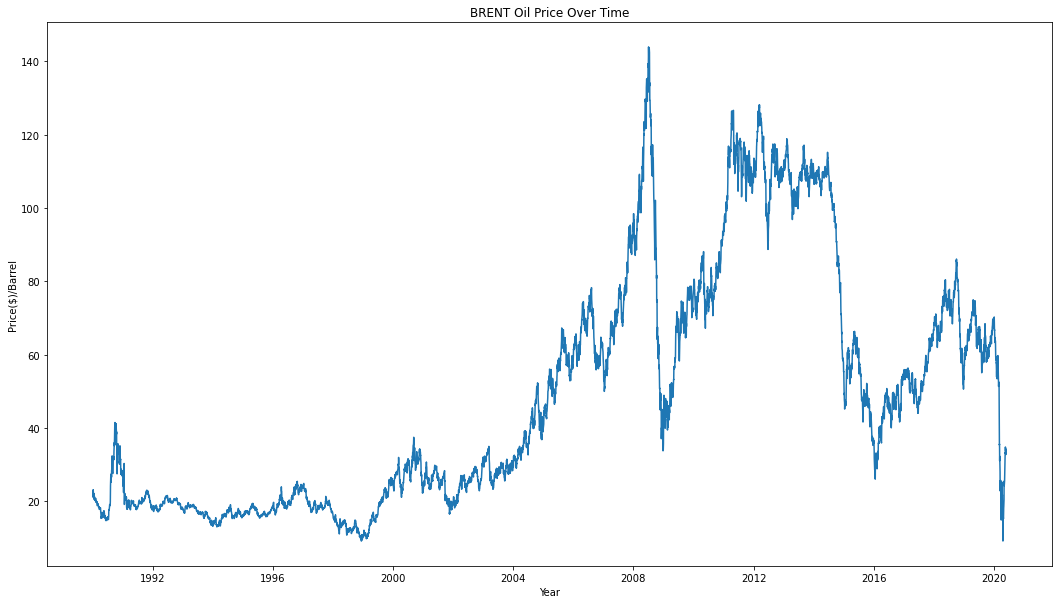

In [5]:
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.title('BRENT Oil Price Over Time')
plt.plot(df['BRENT'])
plt.rcParams["figure.figsize"] = [18,10]

In [6]:
WTI_ts=df['WTI']
BRENT_ts=df['BRENT']

# Step 2: Determine Whether Time Series Data are Stationary 
## Step 2a: Plot the rolling means and rolling standard deviations of time series data
#### The time series is stationary if the means and SD remain constant with time
## Step 2b: Test for Stationarity in the time series data using the Dickey-Fuller Test.
#### If the p-value for this test is > .05 on the test, we accept the null hypothesis and conclude the time series is not stationary. 
#### If the p-value  for this test is <= .05, we reject the null hypothesis and conclude the time series is stationary.
#### If the ADF Statistic is much lower than the critical values, that also confirms the time series is stationary.

In [7]:
def test_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Daily Data Rolling Mean & Standard Deviation')
    plt.rcParams["figure.figsize"] = [18,10]
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

## Stationarity Tests

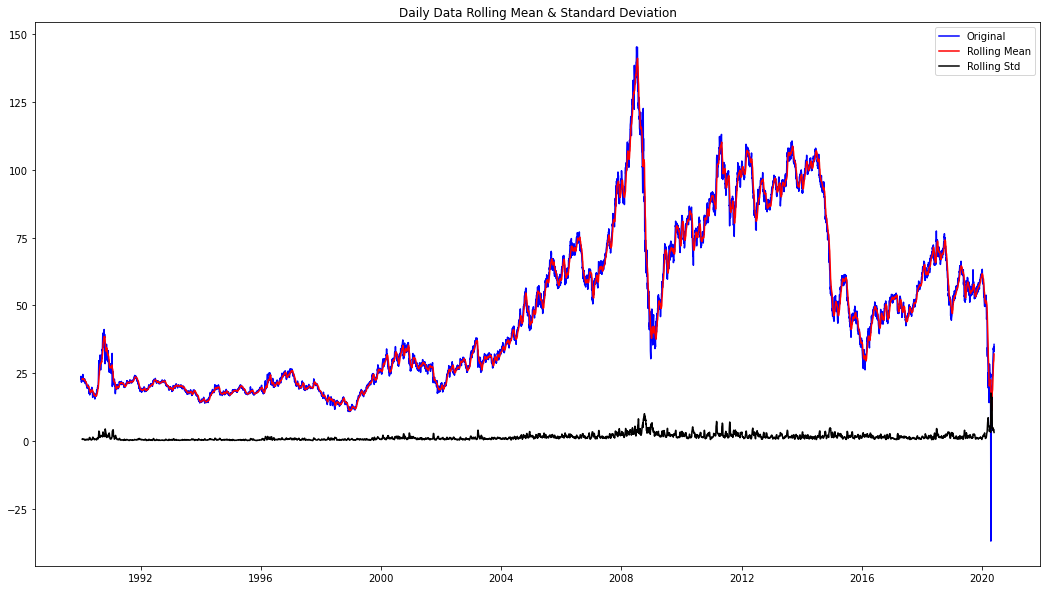

ADF Statistic: -2.1917697809504118
p-value: 0.20924610089033896
Critical Values:
	1%: -3.4312178068782915
	5%: -2.8619235052258047
	10%: -2.5669741354000086


In [8]:
test_stationarity(WTI_ts)

### As we can see in the figure and Dickey Fuller test above, the WTI time series data are not stationary. The rolling mean and SD are not constant over time,  the WTI Dickey Fuller test is  > .05. Thus, we accept the null hypothesis and conclude the data is non-stationary.

## BRENT Stationarity Tests

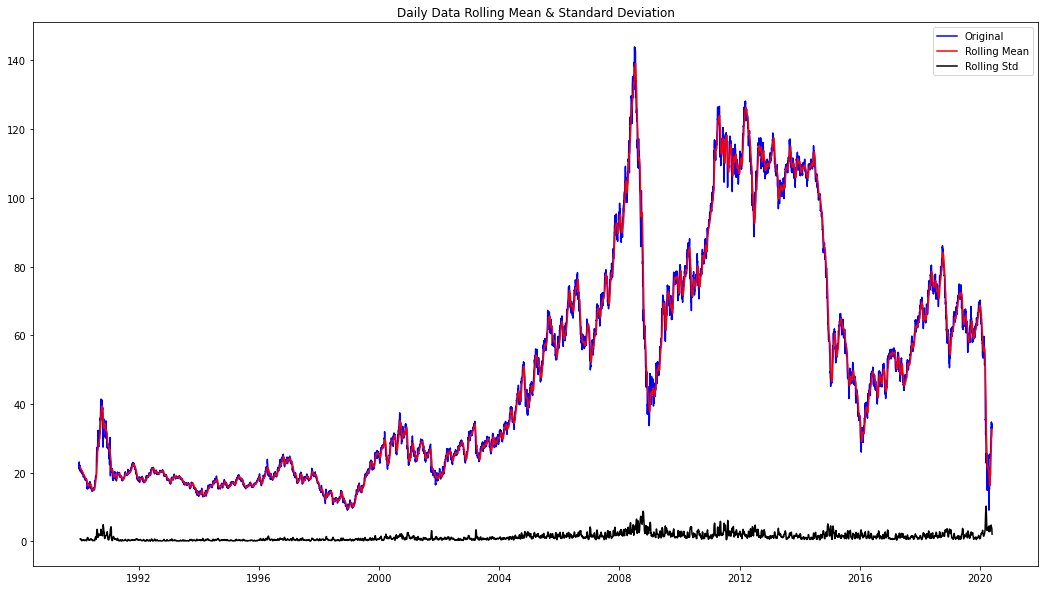

ADF Statistic: -2.0618735404037563
p-value: 0.2601190948847514
Critical Values:
	1%: -3.431217691730046
	5%: -2.8619234543463885
	10%: -2.5669741083162005


In [10]:
test_stationarity(BRENT_ts)

### As we can see in the figure and Dickey Fuller test above, the BRENT time series data are not stationary. The rolling mean and SD are not constant over time,  the WTI Dickey Fuller test is  > .05. Thus, we accept the null hypothesis and conclude the data is non-stationary.

## Differencing the Data - Transform the data 

In [11]:
WTI_log = np.log(WTI_ts)
BRENT_log = np.log(BRENT_ts)
WTI_log_diff = WTI_log - WTI_log.shift()
WTI_log_diff.dropna(inplace=True)
BRENT_log_diff = BRENT_log - BRENT_log.shift()
BRENT_log_diff.dropna(inplace=True)

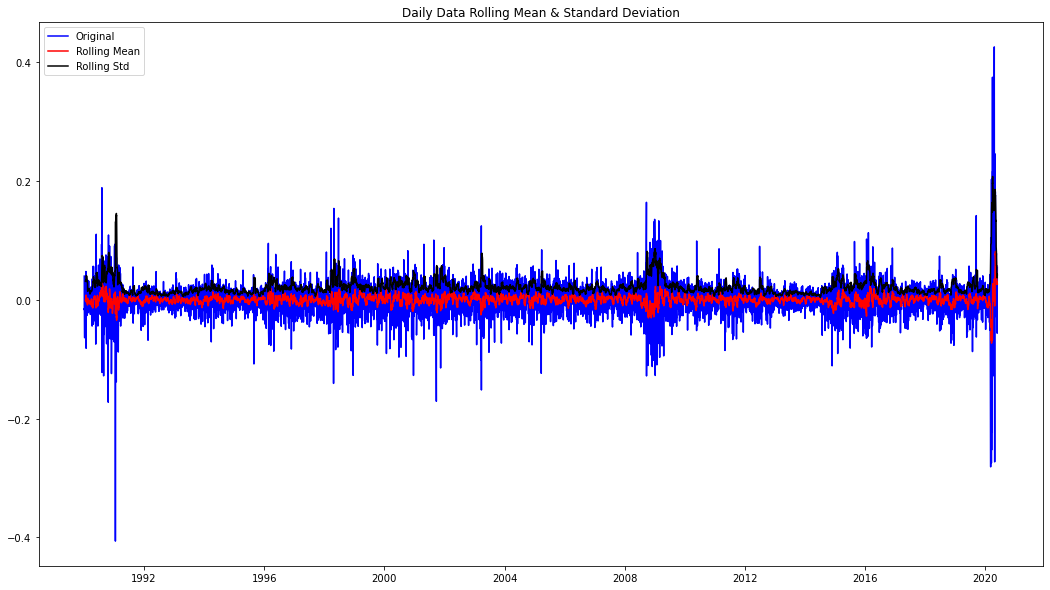

ADF Statistic: -15.413221918446071
p-value: 3.1036116683611566e-28
Critical Values:
	1%: -3.4312180372664933
	5%: -2.8619236070251537
	10%: -2.5669741895891933


In [13]:
test_stationarity(WTI_log_diff)

### As we can see in the figure and Dickey Fuller test above, the transformed log differenced WTI time series data are stationary. The rolling mean and SD are relatively constant over time, the WTI Dickey Fuller test is  < .05, and the ADF statistic is much lower than the critical values. Thus, we can reject the null hypothesis and conclude the data stationary.

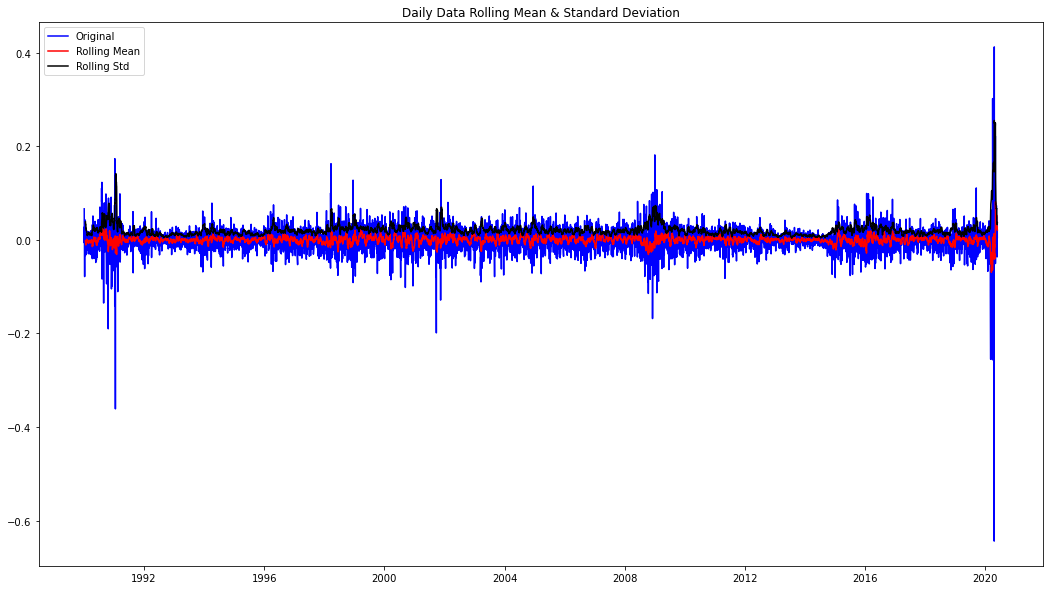

ADF Statistic: -19.145320065214666
p-value: 0.0
Critical Values:
	1%: -3.431216427113213
	5%: -2.8619228955625338
	10%: -2.5669738108679443


In [14]:
test_stationarity(BRENT_log_diff)

### As we can see in the figure and Dickey Fuller test above, the transformed log differenced BRENT time series data are stationary. The rolling mean and SD are relatively constant over time, the WTI Dickey Fuller test is  < .05, and the ADF statistic is much lower than the critical values. Thus, we can reject the null hypothesis and conclude the data stationary.

# Step 3: Explore Autocorrelation Functioms (ACF) and Partial Autocorrelation Functions (PACF)

### ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

### PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

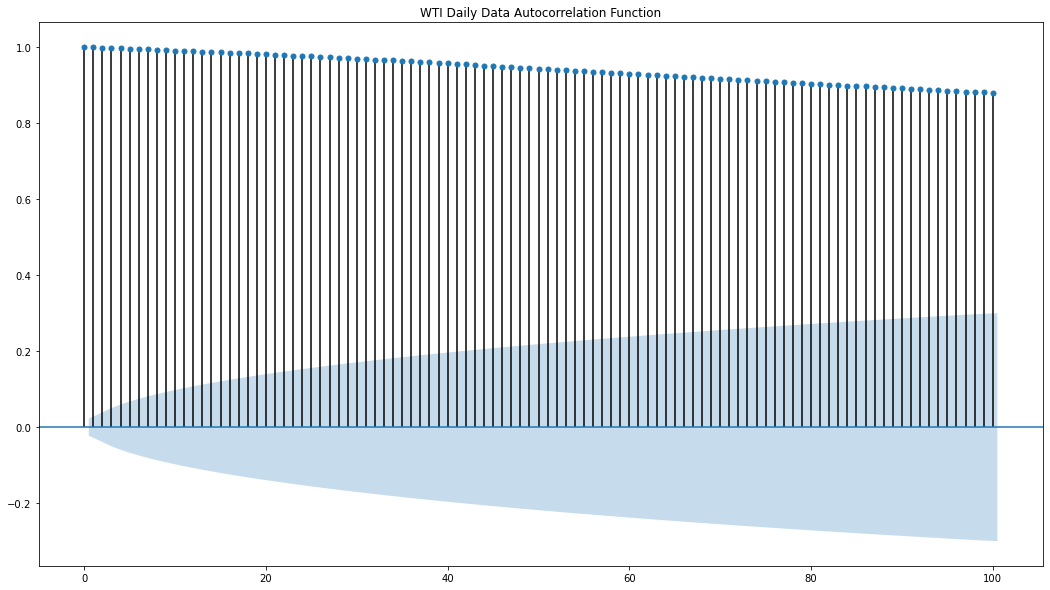

In [15]:
plot_acf(WTI_ts, lags=100)
plt.title('WTI Daily Data Autocorrelation Function')
plt.show()

## From our WTI autocorrelation figure, we see that there is no indication of seasonality and a slight negative trend over time

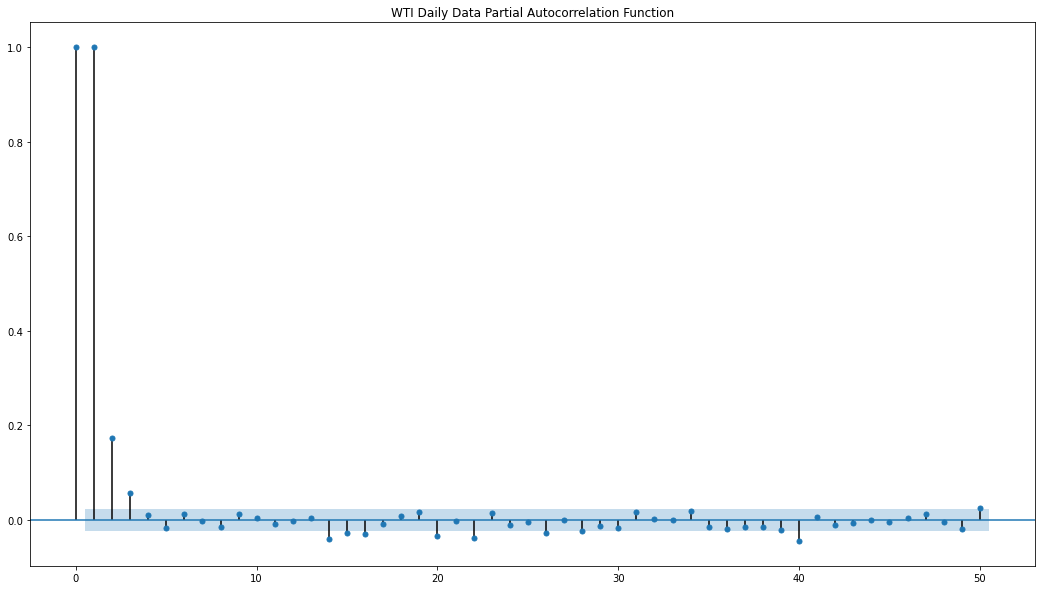

In [16]:
plot_pacf(WTI_ts, lags=50)
plt.title('WTI Daily Data Partial Autocorrelation Function')
plt.show()

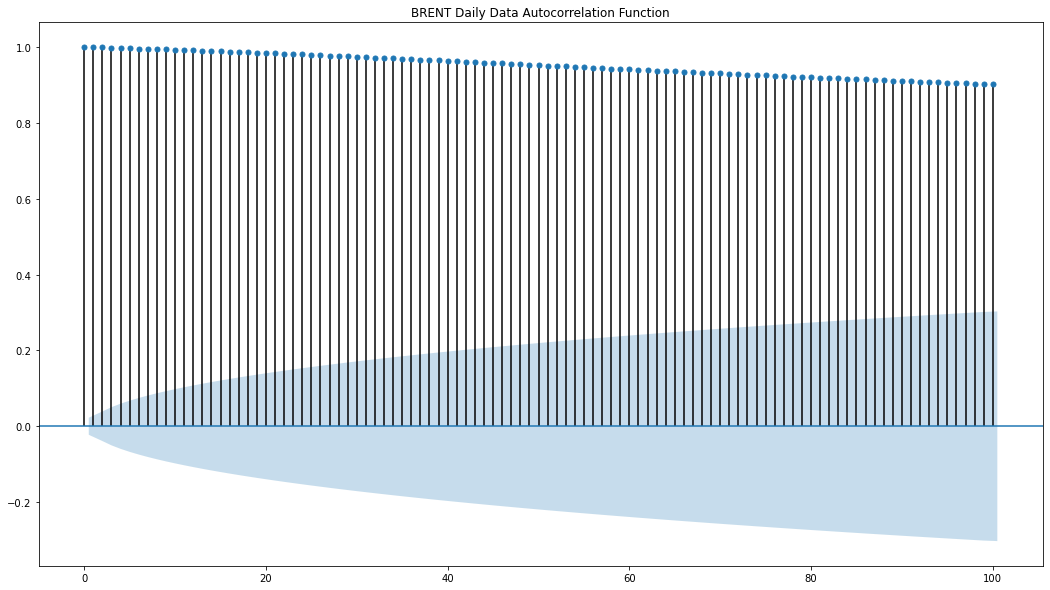

In [17]:
plot_acf(BRENT_ts, lags=100)
plt.title('BRENT Daily Data Autocorrelation Function')
plt.show()

## From our BRENT autocorrelation figure, we see that there is no indication of seasonality and a slight negative trend over time

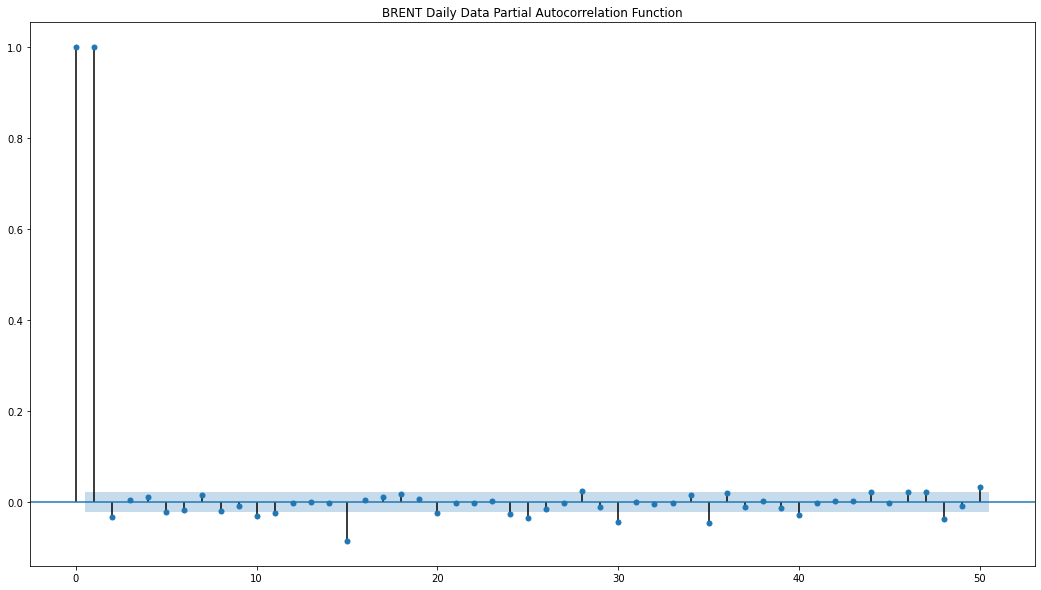

In [18]:
plot_pacf(BRENT_ts, lags=50)
plt.title('BRENT Daily Data Partial Autocorrelation Function')
plt.show()

# STEP 4) Running an ARIMA model

## Step 4a) Spliting the datasets into training and test datasets 

In [19]:
split_date = pd.datetime(2019,1,1)
WTI_train = WTI_ts.loc[WTI_ts.index < split_date]
WTI_test = WTI_ts.loc[WTI_ts.index >= split_date]
BRENT_train = BRENT_ts.loc[BRENT_ts.index < split_date]
BRENT_test = BRENT_ts.loc[BRENT_ts.index >= split_date]
WTI_test

date
2019-01-02    46.31
2019-01-03    46.92
2019-01-04    47.76
2019-01-07    48.27
2019-01-08    49.58
              ...  
2020-05-22    33.49
2020-05-26    34.70
2020-05-27    32.80
2020-05-28    33.67
2020-05-29    35.57
Name: WTI, Length: 351, dtype: float64

## Step 4b) Run auto-ARIMA procedure for evaluating the combinations of p, d and q values to find the best fitting ARIMA models for each oil type.
### ARIMA model paramters:
###     p: The order of the auto-regressive (AR) model (i.e., the number of lag observations)
###     d: The degree of differencing.
###     q: The order of the moving average (MA) model. The size of the “window” function over your time series data.


### Evaluating ARIMA hyperparameters for WTI

In [20]:
WTI_arima_model =  auto_arima(WTI_train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=1, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23342.827, Time=1.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23329.968, Time=3.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23329.268, Time=3.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23340.874, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23329.612, Time=9.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23328.297, Time=4.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23332.751, Time=22.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23328.736, Time=5.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23328.575, Time=32.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=23326.350, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23327.319, Time=1.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=23330.801, Time=6.73 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=23326.788, Time=2.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23327.665, Time=5.77 sec
 ARIMA(1,1,3)(0,0

#### Results: The best fitting ARIMA model for WTI is a (0, 1, 2) model. The summary of the WTI ARIMA model details below.

In [21]:
WTI_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7218
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -11660.175
Date:                Thu, 19 Nov 2020   AIC                          23326.350
Time:                        19:40:01   BIC                          23347.002
Sample:                             0   HQIC                         23333.455
                               - 7218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0458      0.004    -10.689      0.000      -0.054      -0.037
ma.L2         -0.0199      0.007     -2.972      0.003      -0.033      -0.007
sigma2         1.4820      0.008    183.162      0.000       1.466       1.498
===================================================================================
Ljung-Box (Q):                      115.83   Jarque-Bera (JB):             88215.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.88   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluating ARIMA hyperparameters for BRENT

In [22]:
BRENT_arima_model =  auto_arima(BRENT_train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=1, seasonal = True,
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True, method='nm')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22101.020, Time=4.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22095.082, Time=5.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22095.043, Time=6.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22099.115, Time=1.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22097.034, Time=12.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22097.028, Time=5.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22098.957, Time=13.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22093.132, Time=3.68 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22095.124, Time=8.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22095.117, Time=4.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22093.171, Time=3.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22097.045, Time=5.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 73.870 seconds


#### Results: The best fitting ARIMA model for the BRENT daily data is a (0, 1, 1) model. The summary of the BRENT ARIMA model details below.

In [23]:
#Summary of the model
BRENT_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7218
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -11044.566
Date:                Thu, 19 Nov 2020   AIC                          22093.132
Time:                        19:41:15   BIC                          22106.901
Sample:                             0   HQIC                         22097.869
                               - 7218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0333      0.008      4.184      0.000       0.018       0.049
sigma2         1.2497      0.009    132.199      0.000       1.231       1.268
===================================================================================
Ljung-Box (Q):                      135.40   Jarque-Bera (JB):             18041.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.93   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 4c) Compare the predicted oil prices from the ARIMA models against the observed values from our test datasets to test the accuracy of our models

### Comparing the predicted WTI oil prices from our ARIMA models against the test data

In [24]:
#Obtain the ARIMA model's predicted values and 95% CI from 2019 to 2020

WTI_prediction, WTI_confint = WTI_arima_model.predict(n_periods = 351, return_conf_int=True)
WTI_prediction = pd.DataFrame(WTI_prediction,index=WTI_test.index)
WTI_prediction.columns = ['WTI_predicted_oil_price']
WTI_lower_series = pd.Series(WTI_confint[:, 0], index=WTI_test.index)
WTI_upper_series = pd.Series(WTI_confint[:, 1], index=WTI_test.index)

#Calculate the model fit and accuracy scores of ARIMA model for predicitng WTI test data from 2019 to 2020

WTI_accuracy = metrics.r2_score(WTI_test, WTI_prediction)
WTI_ARIMA_MSE = metrics.mean_squared_error(WTI_test, WTI_prediction)

In [25]:
WTI_test.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29'],
              dtype='datetime64[ns]', name='date', length=351, freq=None)

In [ ]:
#Visualising the predictions and original data using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=WTI_train.index,
        y=WTI_train, mode='lines',
        name='WTI Train'))
fig.add_trace(go.Scatter(x=WTI_test.index,
        y=WTI_test,mode='lines',
        name='"WTI Test'))
fig.add_trace(go.Scatter(x=WTI_predictions.index,
        y=WTI_prediction,mode='lines',
        name='WTI ARIMA Predicted'))
fig.update_layout(
    title="f'ARIMA  (0, 1, 2) model for WTI Daily Oil Price Over Time: MSE = {WTI_ARIMA_MSE}",
    xaxis_title="Year",
    yaxis_title="Price($)/Barrel")
fig.show()

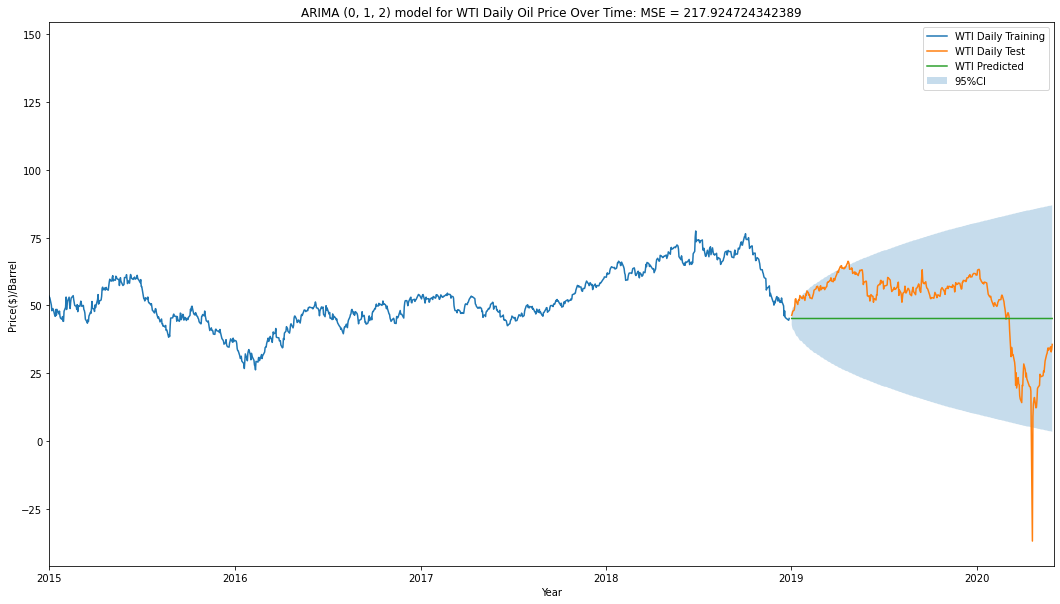

In [26]:
#Visualising the predictions and original data using Matplotlib

plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.plot(WTI_train,label="WTI Daily Training")
plt.plot(WTI_test,label="WTI Daily Test")
plt.plot(WTI_prediction,label="WTI Predicted")
plt.fill_between(WTI_lower_series.index, 
                     WTI_lower_series, 
                     WTI_upper_series, 
                     alpha=0.25, label='95%CI')
plt.title(f'ARIMA (0, 1, 2) model for WTI Daily Oil Price Over Time: MSE = {WTI_ARIMA_MSE}')
plt.legend(loc = 'Left corner')
plt.show()

In [27]:
print(f'The Model fit for the ARIMA model using the daily WTI oil price data is: R2 = {WTI_accuracy} and MSE = {WTI_ARIMA_MSE}')


The Model fit for the ARIMA model using the daily WTI oil price data is: R2 = -0.1941818044185426 and MSE = 217.924724342389


# WTI ARIMA (0, 1, 2) Time Series Model (Daily) Conclusion:
## The ARIMA  (0, 1 ,2) model using the daily oil price data does a poor job of predicting the actual WTI test data from 2019 to 2020. The ARIMA model using the WTI daily data (WTI daily model: R2 = -0.19, MSE = 217.92) peforms slightly worse than than the ARIMA model using the WTI monthly oil price data (WTI monthly model: R2 = -0.23, MSE = 206.87). 

### Comparing the predicted BRENT oil prices from our ARIMA models against the test data

In [28]:
#Obtain the ARIMA model's predicted values and 95% CI from 2019 to 2020

BRENT_prediction, BRENT_confint = BRENT_arima_model.predict(n_periods = 351, return_conf_int=True)
BRENT_prediction = pd.DataFrame(BRENT_prediction,index=BRENT_test.index)
BRENT_prediction.columns = ['BRENT_predicted_oil_price']
BRENT_lower_series = pd.Series(BRENT_confint[:, 0], index=WTI_test.index)
BRENT_upper_series = pd.Series(BRENT_confint[:, 1], index=WTI_test.index)

#Calculate the model fit and accuracy scores of ARIMA model for predicitng WTI test data from 2019 to 2020

BRENT_accuracy = metrics.r2_score(BRENT_test, BRENT_prediction)
BRENT_ARIMA_MSE = metrics.mean_squared_error(BRENT_test, BRENT_prediction)

In [33]:
#Visualising the predictions and original data using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=BRENT_train.index,
        y=BRENT_train, mode='lines',
        name='BRENT Train'))
fig.add_trace(go.Scatter(x=BRENT_test.index,
        y=BRENT_test,mode='lines',
        name='"BRENT Test'))
fig.add_trace(go.Scatter(x=WTI_predictions.index,
        y=BRENT_prediction,mode='lines',
        name='BRENT ARIMA Predicted'))
fig.update_layout(
    title="f'ARIMA  (1, 1, 0) model for BRENT Daily Oil Price Over Time: MSE = {BRENT_ARIMA_MSE}",
    xaxis_title="Year",
    yaxis_title="Price($)/Barrel")

fig.show()

NameError: name 'go' is not defined

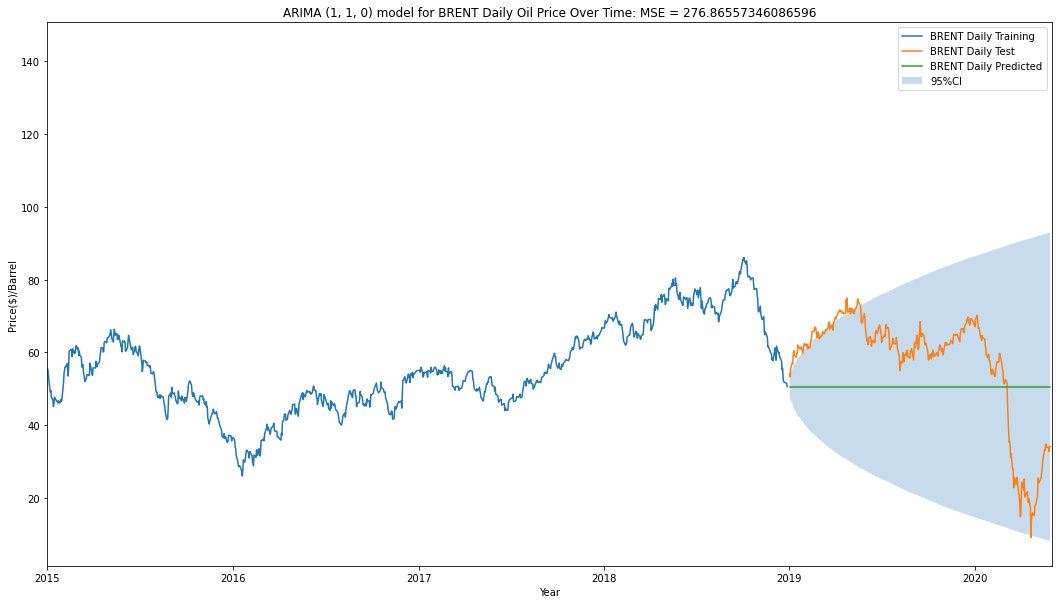

In [32]:
#Visualising the predictions and original data using Matplotlib

plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(BRENT_train,label="BRENT Daily Training")
plt.plot(BRENT_test,label="BRENT Daily Test")
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.plot(BRENT_prediction,label="BRENT Daily Predicted")
plt.fill_between(BRENT_lower_series.index, 
                     BRENT_lower_series, 
                     BRENT_upper_series, 
                     alpha=0.25, label='95%CI')
plt.title(f'ARIMA (1, 1, 0) model for BRENT Daily Oil Price Over Time: MSE = {BRENT_ARIMA_MSE}')
plt.legend(loc = 'Left corner')
plt.show()

In [30]:
print(f'The Model fit for the BRENT ARIMA model using the daily oil price data is: R2 = {BRENT_accuracy} and MSE = {BRENT_ARIMA_MSE}')


The Model fit for the BRENT ARIMA model using the daily oil price data is: R2 = -0.19602758221216243 and MSE = 276.86557346086596


# BRENT ARIMA (1, 1, 0) Time Series Model (Daily) Conclusion:
## The ARIMA  (1, 1, 0) model using the daily oil price data does a poor job of predicting the actual WTI test data from 2019 to 2020.  However, the ARIMA model using the BRENT daily data (BRENT daily model: R2 = -0.20, MSE = 276.87) peforms slightly better than than the ARIMA (1, 1, 0) model using the BRENT monthly oil price data (BRENT monthly model: R2 = -0.10, MSE = 312.67). 

In [31]:
#Export train and test set for RRN models
WTI_train.to_csv("WTI_train.csv")
WTI_test.to_csv("WTI_test.csv")
BRENT_train.to_csv("BRENT_train.csv")
BRENT_test.to_csv("BRENT_test.csv")